In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
import sys
sys.path.insert(1, '/home/gusinskaia/psr_tools')

from glob import glob
import os, math, time
from astropy.time import Time
from astropy.visualization import quantity_support
from astropy import constants as const

import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth
import wsrt_fits as wf
import pickle

plt.rcParams['figure.dpi'] = 50

In [4]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
nsdir=trdir+'dss_wsrt_wnoise/'
list_obs=sorted(glob(nsdir+'*wns*.npz'))
print (list_obs[20])

/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5602866_WSRT_1400_wns.npz


# Fit most observations using Theta-Theta method:

i: 0 obs: /mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5596772_WSRT_1400_wns.npz
(659, 512)
fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1300.94 - 1317 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1308.7671232876712 MHz 55967.720949115814
eta  : 9.064 us / mHz2 mueff: 6.387 mas / yr dveff: 0.546 km / (pc(1/2) s)
e_err: 0.345 us / mHz2 m_err: 0.122 mas / yr v_err: 0.010 km / (pc(1/2) s)
----------
fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1320.98 - 1337 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1328.8062622309196 MHz 55967.720949115814
eta  : 0.821 us / mHz2 mueff: 20.909 mas / yr dveff: 1.787 km / (pc(1/2) s)
e_err: 0.079 us / mHz2 m_err: 1.006 mas / yr v_err: 0.086 km / (pc(1/2) s)
----------
fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1341.02 - 1357 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1348.8454011741683 MHz 55967.720949115814
eta  : 19.924 us / mHz2 mueff: 4.180 mas / yr dveff: 0.357 km / (pc(1/2) s)
e_err: 0.0

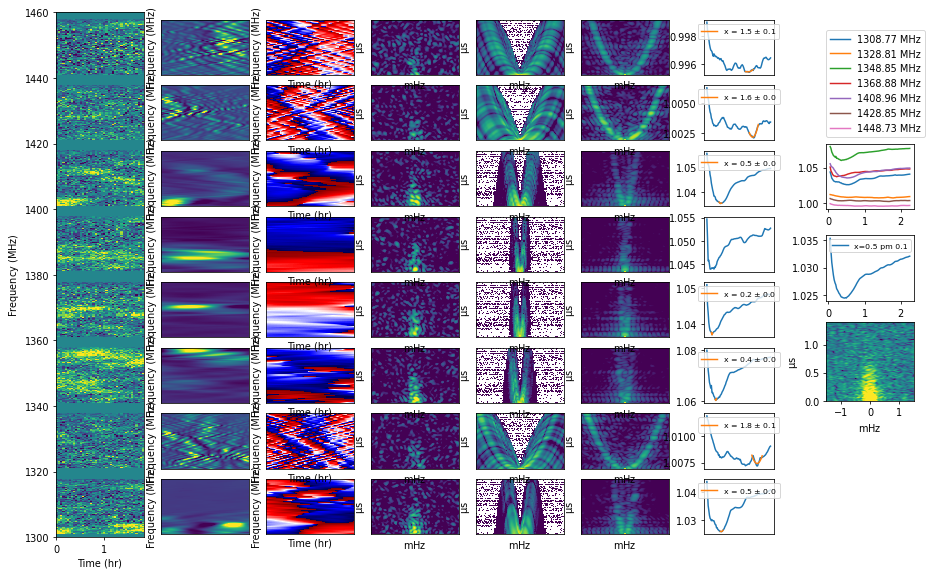

fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1300.94 - 1337 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1318.7866927592952 MHz 55967.720949115814
eta  : 9.217 us / mHz2 mueff: 6.286 mas / yr dveff: 0.537 km / (pc(1/2) s)
e_err: 0.919 us / mHz2 m_err: 0.314 mas / yr v_err: 0.027 km / (pc(1/2) s)
----------
fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1320.98 - 1357 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1338.8258317025438 MHz 55967.720949115814
eta  : 19.186 us / mHz2 mueff: 4.292 mas / yr dveff: 0.367 km / (pc(1/2) s)
e_err: 0.000 us / mHz2 m_err: 0.000 mas / yr v_err: 0.000 km / (pc(1/2) s)
----------
fit: <Dynamic spectrum: Dur: 1.83 hr, Freq: 1341.02 - 1377 MHz, MJD: 55967.72, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1358.8649706457927 MHz 55967.720949115814
eta  : 14.779 us / mHz2 mueff: 4.818 mas / yr dveff: 0.412 km / (pc(1/2) s)
e_err: 0.000 us / mHz2 m_err: 0.000 mas / yr v_err: 0.000 km / (pc(1/2) s)
----------
fit: <Dynamic spectrum: Dur: 1.8

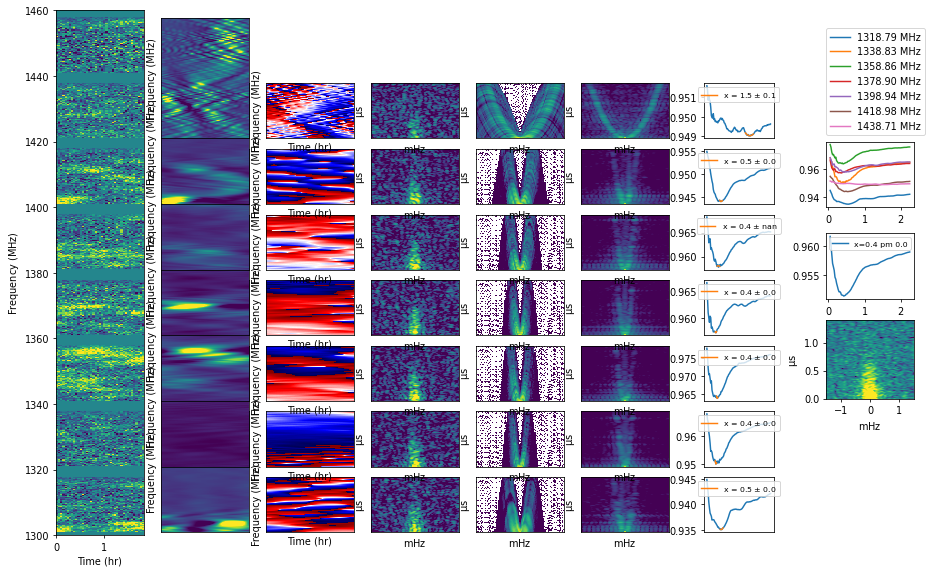

In [65]:
for i in range(0,1):
    print ('i:',i, 'obs:', list_obs[i])
    sa_name='dveff_wnz_nored_short_20220210'
    this_spec=dsa.load_triple_spectrum(list_obs[i], factor=[1,1], wnoise=True, mean0=True)
    my_specs=[]
    if (this_spec.stend[1]-this_spec.stend[0])>3.8/24.:
        break_mjd=(this_spec.stend[1]+this_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)
    else:
        my_specs.append(this_spec)
    
        
    for this_sp in my_specs:
        res_ind=wf.fit_wsrt_spec(this_sp, saveauxname='ind_'+sa_name, curv_par='dveff', wnoise=True,
                                    par_lims=[0.05,2.25], chi2_method='Nina',reduced=False)
        
        res_overlap=wf.fit_wsrt_spec(this_sp, saveauxname='ovlp_'+sa_name, curv_par='dveff', wnoise=True,
                                 pc_overlap=True, save_models=True, par_lims=[0.05,2.25], reduced=False,
                                    chi2_method='Nina')
        
        resuls_all = {'res_ind':res_ind[0:2], 'res_ind_sim':res_ind[5],
                  'res_ovlp_':res_overlap[0:2],'res_ovlp_sim':res_overlap[5]}
        
        with open('res_all_%.2f_%s_%s.pickle'%(this_sp.stend[0],this_sp.tel,sa_name), 'wb') as e:
            pickle.dump(resuls_all, e, pickle.HIGHEST_PROTOCOL)
        with open('%sspec_triple_%.2f_%s.pickle'%(trdir,this_sp.mjd.mjd.mean(),this_sp.tel), 'wb') as e:
            pickle.dump(this_sp, e, pickle.HIGHEST_PROTOCOL)

# Get info from result pickles

In [8]:
res_dir='/mnt/scratch-lustre/gusinskaia/triple_system/results/res_20211111/full_pickle_results_20210315'

In [60]:
list_pickles=sorted(glob('%s/*nodof*.pickle'%res_dir))
print (len(list_pickles))

#for i in range(0,len(list_pickles)):
#    print (i, list_pickles[i].split('/')[-1])

263


In [56]:
res_pickle=pickle.load(open(list_pickles[0], 'rb'))
res_pickle

{'res_ind': ([{'eta': <Quantity 9.58036788 us / mHz2>,
    'mueff': <Quantity 6.21219653 mas / yr>,
    'dveff': <Quantity 0.53084192 km / (pc(1/2) s)>,
    'eta_err': <Quantity 0.77140635 us / mHz2>,
    'mueff_err': <Quantity 0.25010145 mas / yr>,
    'dveff_err': <Quantity 0.02137156 km / (pc(1/2) s)>,
    'mean_f': <Quantity 1308.92367906 MHz>,
    'mean_t': 55967.720949115814},
   {'eta': <Quantity 0.80923762 us / mHz2>,
    'mueff': <Quantity 21.05230928 mas / yr>,
    'dveff': <Quantity 1.79895278 km / (pc(1/2) s)>,
    'eta_err': <Quantity 0.07235182 us / mHz2>,
    'mueff_err': <Quantity 0.94111597 mas / yr>,
    'dveff_err': <Quantity 0.08041983 km / (pc(1/2) s)>,
    'mean_f': <Quantity 1328.962818 MHz>,
    'mean_t': 55967.720949115814},
   {'eta': <Quantity 15.3247475 us / mHz2>,
    'mueff': <Quantity 4.76586088 mas / yr>,
    'dveff': <Quantity 0.40725027 km / (pc(1/2) s)>,
    'eta_err': <Quantity 0. us / mHz2>,
    'mueff_err': <Quantity 0. mas / yr>,
    'dveff_err': 

In [66]:
def print_fits_wsrt(res_pickle):
    res_dveffs_ind=[]
    res_dveffs_err_ind=[]
    res_freqs_ind=[]

    for i in range(0,8):
        res_dveffs_ind.append(res_pickle['res_ind'][0][i]['dveff'].value)
        res_dveffs_err_ind.append(res_pickle['res_ind'][0][i]['dveff_err'].value)
        res_freqs_ind.append(res_pickle['res_ind'][0][i]['mean_f'].value)

    res_dveffs_ovlp=[]
    res_dveffs_err_ovlp=[]
    res_freqs_ovlp=[]

    for i in range(0,7):
        res_dveffs_ovlp.append(res_pickle['res_ovlp_'][0][i]['dveff'].value)
        res_dveffs_err_ovlp.append(res_pickle['res_ovlp_'][0][i]['dveff_err'].value)
        res_freqs_ovlp.append(res_pickle['res_ovlp_'][0][i]['mean_f'].value)

    plt.figure(figsize=(4,2), dpi=150)    
    plt.errorbar(res_freqs_ind,res_dveffs_ind, yerr=res_dveffs_err_ind,ls=':', marker='o')
    plt.errorbar(res_freqs_ovlp,res_dveffs_ovlp, yerr=res_dveffs_err_ovlp, ls='-', marker='s')
    plt.ylabel('dveff')
    plt.xlabel('frequency, MHz')
    plt.title('%.2f'%(res_pickle['res_ind'][0][0]['mean_t']-0.04))
    plt.show()
    print ('individual')
    for i in range(0,len(res_dveffs_ind)):
        print (i, ' - %.2f'%res_freqs_ind[i], ' - %.1f'%res_dveffs_ind[i])
    
    print ('Overlap')
    for i in range(0,len(res_dveffs_ovlp)):
        print (i, ' - %.2f'%res_freqs_ovlp[i], ' - %.1f'%res_dveffs_ovlp[i])
    

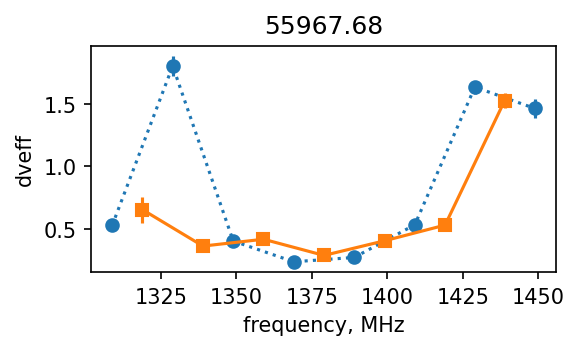

individual
0  - 1308.92  - 0.531
1  - 1328.96  - 1.799
2  - 1349.00  - 0.407
3  - 1369.04  - 0.242
4  - 1389.08  - 0.277
5  - 1409.12  - 0.536
6  - 1429.00  - 1.632
7  - 1448.88  - 1.461
Overlap
0  - 1318.94  - 0.657
1  - 1338.98  - 0.367
2  - 1359.02  - 0.421
3  - 1379.06  - 0.293
4  - 1399.10  - 0.409
5  - 1419.14  - 0.534
6  - 1438.86  - 1.523


In [64]:
print_fits_wsrt(res_pickle)

# Let's remove all the bad fits
This is done by looking at fitting plots with ds, ss models as well as chisq curves

In [53]:
mylist=[1,2,3,4,5,6,7,8,9,10]


In [54]:
mylist.pop(2)

3

In [55]:
mylist

[1, 2, 4, 5, 6, 7, 8, 9, 10]